In [ ]:
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.preprocessing import image
from tensorflow.keras import models
from tensorflow.keras.models import load_model
from tensorflow.keras import models
from PIL import Image 
from skimage.io import imread
import cv2
import os
import warnings
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

n_classes = 10
batch_size = 32
img_width, img_height = 299, 299

train_data_dir = '/content/drive/MyDrive/dataset/train'

# Data Augmentation with ImageDataGenerator
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical')

val_data_dir = '/content/drive/MyDrive/dataset/test'

val_datagen = ImageDataGenerator(rescale=1. / 255)

val_generator = val_datagen.flow_from_directory(
    val_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical')

Found 464 images belonging to 10 classes.
Found 100 images belonging to 10 classes.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
class_map = train_generator.class_indices
class_map

{'burger': 0,
 'chapati': 1,
 'chicken': 2,
 'chilliparotta': 3,
 'cornflakes': 4,
 'crispychicken': 5,
 'curdrice': 6,
 'dosa': 7,
 'frenchfries': 8,
 'idli': 9}

In [ ]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
# from tensorflow.keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D, GlobalAveragePooling2D, AveragePooling2D
# from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten

from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import Dense, Dropout

from tensorflow.keras import regularizers
from tensorflow.keras.regularizers import l2

from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger

nb_train_samples = 926 
nb_validation_samples = 210

inception = InceptionV3(weights='imagenet', include_top=False)
x = inception.output
x = GlobalAveragePooling2D()(x)
x = Dense(128,activation='relu')(x)
x = Dropout(0.2)(x)

predictions = Dense(n_classes,kernel_regularizer=regularizers.l2(0.005), activation='softmax')(x)

model = Model(inputs=inception.input, outputs=predictions)
model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])
checkpointer = ModelCheckpoint(filepath='v1_inceptionV3', verbose=1, save_best_only=True)
csv_logger = CSVLogger('history_v1_inceptionV3.log')

history = model.fit_generator(train_generator,
                    steps_per_epoch = nb_train_samples // batch_size,
                    validation_data=val_generator,
                    validation_steps=nb_validation_samples // batch_size,
                    epochs=10,
                    verbose=1,
                    callbacks=[csv_logger, checkpointer])

<ipython-input-8-b756e75aba8b>:31: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_generator,


Epoch 1/10
15/28 [===============>..............] - ETA: 1:29 - loss: 1.7548 - accuracy: 0.4591


Epoch 1: val_loss improved from inf to 1.03073, saving model to v1_inceptionV3


28/28 [==============================] - 186s 6s/step - loss: 1.7548 - accuracy: 0.4591 - val_loss: 1.0307 - val_accuracy: 0.6300


In [ ]:
model.save('/content/drive/MyDrive/modelfolder/model_v2.h5')

NameError: ignored

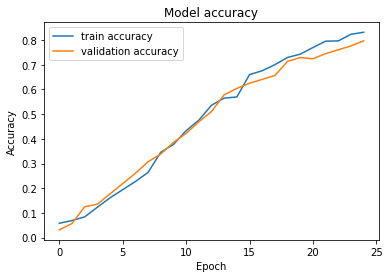

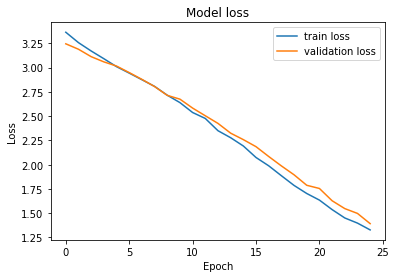

In [ ]:
def plot_accuracy(history):
    
    plt.plot(history.history['accuracy'],label='train accuracy')
    plt.plot(history.history['val_accuracy'],label='validation accuracy')
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='best')
    plt.savefig('Accuracy_v1_InceptionV3')
    plt.show()
    
def plot_loss(history):
    
    plt.plot(history.history['loss'],label="train loss")
    plt.plot(history.history['val_loss'],label="validation loss")
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='best')
    plt.savefig('Loss_v1_InceptionV3')
    plt.show()
    
plot_accuracy(history)
plot_loss(history)

In [ ]:
path_to_model='/content/drive/MyDrive/modelfolder/model_v2.h5'
print("Loading the model..")
model = load_model(path_to_model)
print("Done!")

Loading the model..
Done!


In [ ]:
import tensorflow as tf
model=tf.keras.models.load_model('/content/drive/MyDrive/modelfolder/model_v2.h5')
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.experimental_new_converter = True
tflite_model = converter.convert()
open("converted_model.tflite", "wb").write(tflite_model) 

88186924

In [ ]:
category={
  0 : ['burger','Burger'], 1 : ['chapati','Chapati'], 2 : ['chicken','Chicken']
  ,3 : ['chilliparotta','Chilli Parotta'], 4 :['cornflakes','Corn Flakes'], 5 : ['crispychicken','Crispy Chicken'],
  6 : ['curdrice','Curd Rice'], 7 : ['dosa','Dosa'], 8 : ['frenchfires','French Fries'], 9 :['idli','Idli'], 10 :['kesari','Kesari'],
  11 : ['lemonrice','Lemon Rice'], 12:['naan','Naan'], 13 : ['oats','Oats'], 14: ['paneergravy','Paneer Gravy'],
  15 : ['pizza','Pizza'], 16 : ['puttu','Puttu'], 17 :['shawarmaa','Shawarmaa'], 18 : ['vada','Vada'],
  19 : ['venpongal','Ven Pongal'], 20 :['vermicelli','Vermicelli']
}

In [ ]:
def predict_image(filename,model):
    img_ = image.load_img(filename, target_size=(299, 299))
    img_array = image.img_to_array(img_)
    img_processed = np.expand_dims(img_array, axis=0) 
    img_processed /= 255.   
    
    prediction = model.predict(img_processed)
    
    index = np.argmax(prediction)
    
    plt.title("Prediction - {}".format(category[index][1]))
    plt.imshow(img_array)

1/1 [==============================] - 0s 34ms/step


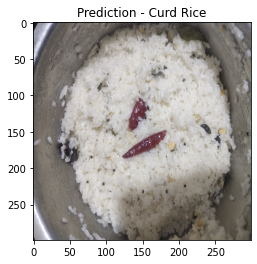

In [ ]:
predict_image('/content/Sample2.jpg',model)

1/1 [==============================] - 0s 32ms/step


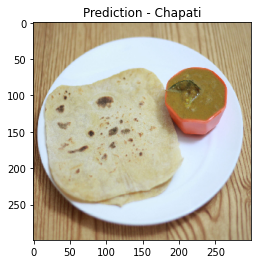

In [ ]:
predict_image('/content/chapati.jpg',model)

1/1 [==============================] - 0s 35ms/step


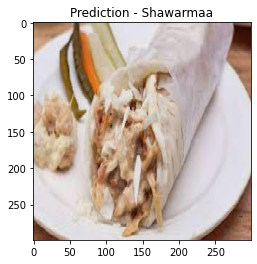

In [ ]:
predict_image('/content/shawarma.jpg',model)

1/1 [==============================] - 0s 47ms/step


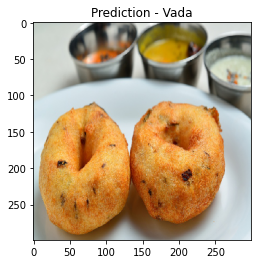

In [ ]:
predict_image('/content/vada.jpg',model)

1/1 [==============================] - 0s 57ms/step


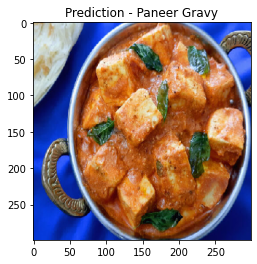

In [ ]:
predict_image('/content/paneergravy.jpg',model)

1/1 [==============================] - 0s 49ms/step


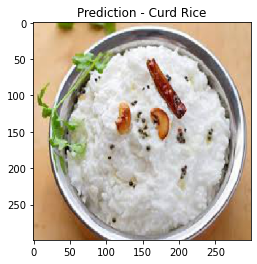

In [ ]:
predict_image('/content/curdrice.jpg',model)

1/1 [==============================] - 0s 58ms/step


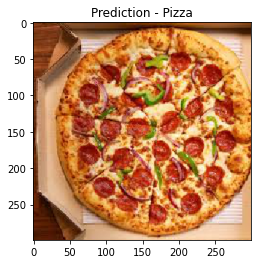

In [ ]:
predict_image('/content/pizza.jpg',model)

1/1 [==============================] - 0s 46ms/step


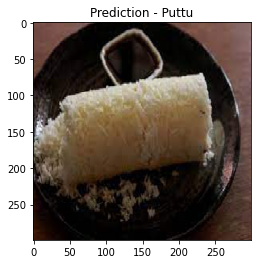

In [ ]:
predict_image('/content/puttu.jpg',model)

1/1 [==============================] - 0s 32ms/step


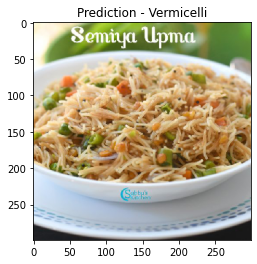

In [ ]:
predict_image('/content/vermicelli.jpg',model)

1/1 [==============================] - 0s 38ms/step


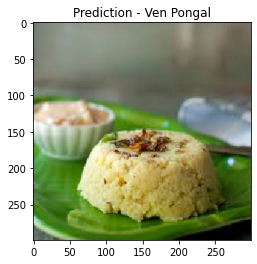

In [ ]:
predict_image('/content/venpongal.jpg',model)

1/1 [==============================] - 0s 31ms/step


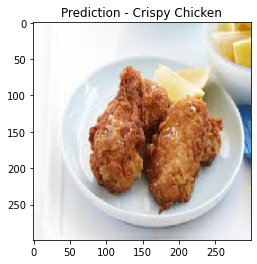

In [ ]:
predict_image('/content/crispychicken.jpg',model)